# About this practical session
In this practical session, we will analyze mobility data for the US coming from *Kang, Yuhao, et al. "Multiscale dynamic human mobility flow dataset in the US during the COVID-19 epidemic." Scientific Data 7.1 (2020): 390*.

Goal: Start with high-resolution human mobility data to extract and visualize the properties of the resulting mobility network

Outline:
- Data inspection, formatting, aggregation, and basic statistics
- Compute the degree distribution of the mobility network
- Create a choropleth map
- Analyze mobility changes during COVID-19 and compare long and short travels
- Fit a generalized gravity model
- Graph representation 
- Compute the risk of importation

## Data details 
To convert the raw GPS pings into individual flows between different locations several are performed:

- Raw GPS Pings
- Noise Removal
- Clustering GPS pings
- Home Location Estimation (Each user's home location is determined based on the most common nighttime location over a six-week period. This is done by clustering GPS pings that occur during nighttime hours (6 PM - 7 AM))
- POIs (Points of Interest) Estimation (Points of Interest (POIs) are tracked using clustering methods that associate each cluster of pings with a POI or a geographic location)
- Visits from home place to various POIs and CBGs are identified
- Population Flow Estimation: Since the mobile phone data only covers about 10% of the population, the study uses demographic data to infer population-level flows. This involves scaling the observed mobile phone data to represent the entire population.

We are going to use the daily Origin-Destination (OD) Matrix that contains the flow between each pair of Census Block Groups (CBG). In other words, this metric estimates the number of individuals who travel from an origin CBG to a destination CBG each day.

# Import libraries

In [1]:
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
import matplotlib as mpl
import matplotlib.dates as mdates

import os
import geopandas as gpd
import statsmodels.api as sm

In [2]:
# If you encounter an ImportError try install packages using the following command:
# !pip install geopandas

In [3]:
# A function for formatting dates in plots
def dateFormat(ax):
    locator = mdates.AutoDateLocator(minticks=5, maxticks=10)
    formatter = mdates.ConciseDateFormatter(locator, show_offset=False)
    ax.xaxis.set_major_locator(locator)
    ax.xaxis.set_major_formatter(formatter)

# Inspect a sample of the data

In [4]:
# Read a sample of the daily CBG to CBG visitor flows.
# If executing on Google Colab, change the path to:
# https://github.com/EPIcx-lab/ESPIDAM2024_Networks-and-Contact-Patterns-in-Infectious-Disease-Models/raw/main/mobilityflows/sample_daily_ct2ct_2020_01_01.csv.xz

ct2ct = pd.read_csv('./mobilityflows/sample_daily_ct2ct_2020_01_01.csv.xz')

In [5]:
# Display the first two entries of the dataset
ct2ct.head(2)

,geoid_o,geoid_d,lng_o,lat_o,lng_d,lat_d,date,visitor_flows,pop_flows
0,1001020100,1001020100,-86.490076,32.477185,-86.490076,32.477185,2020-01-01,166,1596.0
1,1001020100,1001020200,-86.490076,32.477185,-86.473375,32.474248,2020-01-01,8,76.0


## Get county and state from geoids
Geographic identifiers (geoids) in the U.S., like `55025010702`, are constructed as:  
- State FIPS Code: Two digits represent the state (`55` is the FIPS code for Wisconsin).
- County FIPS Code: The next three digits represent the county (`025` is the FIPS code for Dane County in Wisconsin).
- Tract Code: The rest of the digits represent the census tract within the county

In [6]:
# Ensure that GEOIDs are strings of 11 characters by adding leading zeros if necessary
# Hint: use .astype(str) 
...
ct2ct['geoid_o'] = ct2ct['geoid_o'].astype(str)
ct2ct['geoid_d'] = ct2ct['geoid_d'].astype(str)

# Hint: use .apply(...)  
ct2ct['geoid_o'] = ct2ct['geoid_o'].apply(lambda a: a.zfill(11))
ct2ct['geoid_d'] = ct2ct['geoid_d'].apply(lambda a: a.zfill(11))

In [7]:
ct2ct.head(2)

,geoid_o,geoid_d,lng_o,lat_o,lng_d,lat_d,date,visitor_flows,pop_flows
0,01001020100,01001020100,-86.490076,32.477185,-86.490076,32.477185,2020-01-01,166,1596.0
1,01001020100,01001020200,-86.490076,32.477185,-86.473375,32.474248,2020-01-01,8,76.0


In [8]:
# Extract the first 2 characters to represent the state code
# Hint: use .apply(lambda a: ...), and assign the result to a new column
...
ct2ct['state_o'] = ct2ct['geoid_o'].apply(lambda a: a[0:2])
ct2ct['state_d'] = ct2ct['geoid_d'].apply(lambda a: a[0:2])

# Extract the first 5 characters to represent the county code
...
ct2ct['county_o'] = ct2ct['geoid_o'].apply(lambda a: a[0:5])
ct2ct['county_d'] = ct2ct['geoid_d'].apply(lambda a: a[0:5])

In [9]:
ct2ct.head(2)

,geoid_o,geoid_d,lng_o,lat_o,lng_d,lat_d,date,visitor_flows,pop_flows,state_o,state_d,county_o,county_d
0,01001020100,01001020100,-86.490076,32.477185,-86.490076,32.477185,2020-01-01,166,1596.0,01,01,01001,01001
1,01001020100,01001020200,-86.490076,32.477185,-86.473375,32.474248,2020-01-01,8,76.0,01,01,01001,01001


## Aggreagte at state and county level

In [10]:
# Group all entries with the same combination of 'county_o' and 'county_d' and sum the 'pop_flows'
# Hint: Use groupby on 'county_o' and 'county_d' ∫and sum the 'pop_flows' column
...
c2c = ct2ct.groupby(['county_o', 'county_d'])[['pop_flows']].sum()
s2s = ct2ct.groupby(['state_o', 'state_d'])[['pop_flows']].sum()

In [11]:
c2c.head(5)

pop_flows
county_o county_d           
01001    01001       73729.0
         01003         321.0
         01005          10.0
         01007          95.0
         01009          15.0

In [12]:
s2s.head(5)

pop_flows
state_o state_d           
01      01       7372923.0
        02           404.0
        04          4067.0
        05          6541.0
        06         19218.0

# Read pre-aggregated data
Due to time constraints and the large size of the data, we directly read the results of the previous code

In [13]:
# Read county to county csv file
# (if executed on Google Colab change the path in 'https://github.com/EPIcx-lab/ESPIDAM2024_Networks-and-Contact-Patterns-in-Infectious-Disease-Models/raw/main/mobilityflows/mobilityFlowsCounty.csv.xz')
 
c2c = pd.read_csv('./mobilityflows/mobilityFlowsCounty.csv.xz')
c2c['date'] = pd.to_datetime(c2c['date']) # transform column in datetime

In [14]:
# Ensure 'county_o' and 'county_d' are strings and containing 5 characters (adding leading zeros if necessary)
# Hint: similar to what done before

c2c['county_o'] = c2c['county_o'].astype(str)
c2c['county_o'] = c2c['county_o'].apply(lambda a: a.zfill(5))

c2c['county_d'] = c2c['county_d'].astype(str)
c2c['county_d'] = c2c['county_d'].apply(lambda a: a.zfill(5))

In [15]:
# Display 10 random rows from the dataset
c2c.sample(10)

,county_o,county_d,pop_flows,date
18148812,51683,22071,37.0,2020-03-02
12156931,48223,13063,10.0,2020-03-19
8537270,29051,18035,41.0,2020-03-24
933165,05023,29095,43.0,2020-03-09
14384939,29165,15003,302.0,2020-03-14
8779035,19029,20091,10.0,2020-03-24
16298303,31055,37091,16.0,2020-03-29
3940879,04021,26149,14.0,2020-04-03
17192771,19029,48027,9.0,2020-03-03
19067304,37021,17119,17.0,2020-03-12


In [16]:
# Print the number of entries in the dataset
print(f'Dataset entries: {len(c2c):_}')

Dataset entries: 23_787_035


In [17]:
# Print the start and end dates of the dataset
# Hint: use function .min(), .max
...
print(f'Starting date: {c2c["date"].min().date()}')
print(f'Ending date: {c2c["date"].max().date()}')

Starting date: 2020-03-02
Ending date: 2020-04-15


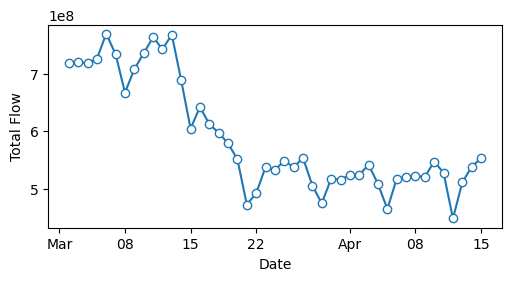

In [18]:
# Compute total population flows per day
# Hint: Group by the 'date' column and sum the 'pop_flows' column
totalFlow = c2c.groupby('date')['pop_flows'].sum()
 
# Plot the timeseries of the total population flows
fig, ax = plt.subplots(figsize=(5, 2.7), layout='constrained')
ax.plot(totalFlow.index, totalFlow.values, marker='o', markerfacecolor='white')

ax.set_ylabel("Total Flow")
ax.set_xlabel("Date")
dateFormat(ax)

Text(0.5, 0, 'w')

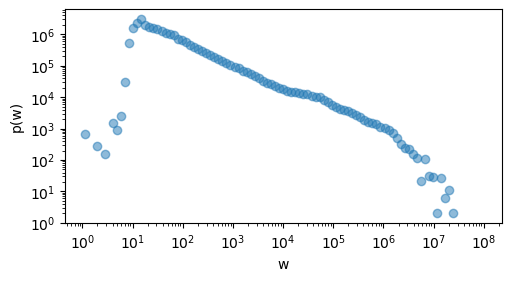

In [19]:
# Plot the distribution of the flow
fig, ax = plt.subplots(figsize=(5, 2.7), layout='constrained')

# Get the histogram of the flow data
# Hint: use the function np.histogram
...
counts, binEdges = np.histogram(c2c['pop_flows'], bins=np.logspace(0, 8, 100))
binCenter = (binEdges[:-1] + binEdges[1:]) / 2
ax.scatter(binCenter, counts, alpha=0.5)

ax.set_xscale("log")
ax.set_yscale("log")
ax.set_ylabel("p(w)")
ax.set_xlabel("w")

# Deegre and Flow Distribution

## Degree distibition

In [20]:
# Select data for a specific day
c2cOneDay = c2c.query('date == "2020-03-02"')

# Filter the data for population flows greater than or equal to 100
# (You can try different filtering criteria)
...
c2cOneDay = c2cOneDay.query('pop_flows >= 100')

# Compute the degree: group by origin/destination and count the number of connections
...
inDegree = c2cOneDay.groupby('county_d')['county_o'].count()
outDegree = c2cOneDay.groupby('county_o')['county_d'].count()

# Rename the resulting series for clarity
inDegree.name = 'inDegree'
outDegree.name = 'outDegree'

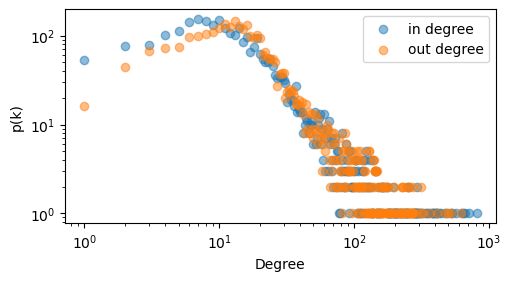

In [21]:
# Plot the degree distribution
fig, ax = plt.subplots(figsize=(5, 2.7), layout='constrained')

# Get the histogram of the in-degree using np.unique with return_counts=True
unique, counts = np.unique(inDegree, return_counts=True)
ax.scatter(unique, counts, alpha=0.5, label='in degree')

# Get the histogram of the out-degree using np.unique with return_counts=True
unique, counts = np.unique(outDegree, return_counts=True)
ax.scatter(unique, counts, alpha=0.5, label='out degree')

ax.set_xscale("log")
ax.set_yscale("log")
ax.set_ylabel("p(k)")
ax.set_xlabel("Degree")
ax.legend()

## In Flow and Out Flow distibition

In [22]:
# Filter data for the specified date range
c2cFiltered = c2c.query('"2020-03-01" <= date <= "2020-03-08"')

# Aggregate population flows by origin and destination counties
c2cFiltered = c2cFiltered.groupby(['county_o', 'county_d'])['pop_flows'].sum().reset_index()

# Compute the in/out flow by summing over all connections grouped by origin/destination
inFlow = c2cFiltered.groupby('county_d')['pop_flows'].sum()
outFlow = c2cFiltered.groupby('county_o')['pop_flows'].sum()

# Rename the resulting series for clarity
inFlow.name = 'inFlow'
outFlow.name = 'outFlow'

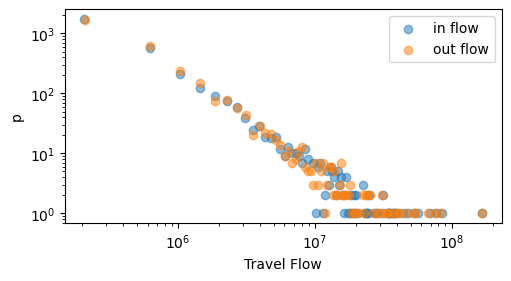

In [23]:
# Plot the distribution of inFlow and outFlow
fig, ax = plt.subplots(figsize=(5, 2.7), layout='constrained')

# Get the histogram of the inFlow data
counts, binEdges = np.histogram(inFlow, bins=400)
binCenter = (binEdges[:-1] + binEdges[1:]) / 2
ax.scatter(binCenter, counts, alpha=0.5, label='in flow')

# Get the histogram of the outFlow data
counts, binEdges = np.histogram(outFlow, bins=400)
binCenter = (binEdges[:-1] + binEdges[1:]) / 2
ax.scatter(binCenter, counts, alpha=0.5, label='out flow')

ax.set_xscale("log")
ax.set_yscale("log")
ax.set_ylabel("p")
ax.set_xlabel("Travel Flow")
ax.legend()

# Plot maps

In [24]:
# Load the shapefile at the county level
# If executing on Google Colab, change the path to:
# https://github.com/EPIcx-lab/ESPIDAM2024_Networks-and-Contact-Patterns-in-Infectious-Disease-Models/raw/main/otherData/US-counties.geojson

geoData = gpd.read_file('./otherData/US-counties.geojson')

# Convert the coordinate reference system to ESRI:102003
geoData = geoData.to_crs("ESRI:102003")

# Set the index to 'id' for easy access
geoData = geoData.set_index('id')

# For visualization purposes, remove Alaska, Hawaii, and Puerto Rico
geoData = geoData.query('STATE not in ["02", "15", "72"]')

## Inspect the map dataset

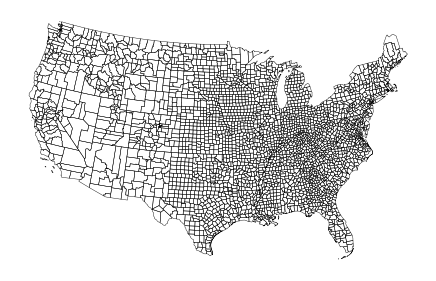

In [25]:
# Plot the county boundaries
fig, ax = plt.subplots(figsize=(5, 2.7), layout='constrained')
geoData.plot(facecolor='None', linewidth=0.3, ax=ax)

# Remove the axis
ax.axis('off');

## Plot the degree

In [26]:
geoData.head(2)

,GEO_ID,STATE,COUNTY,NAME,LSAD,CENSUSAREA,geometry
id,,,,,,,
01001,0500000US01001,01,001,Autauga,County,594.436,"POLYGON ((888385.589 -532160.711, 867146.329 -..."
01009,0500000US01009,01,009,Blount,County,644.776,"POLYGON ((865138.928 -375110.799, 847724.195 -..."


In [27]:
# Merge geoData with inFlow, outFlow, inDegree, and outDegree.
# Hint: geoData = geoData.merge(...)

geoData = geoData.merge(inFlow, left_index=True, right_index=True, how='left')
geoData = geoData.merge(outFlow, left_index=True, right_index=True, how='left')
geoData = geoData.merge(inDegree, left_index=True, right_index=True, how='left')
geoData = geoData.merge(outDegree, left_index=True, right_index=True, how='left')

<Axes: title={'center': 'outFlow'}>

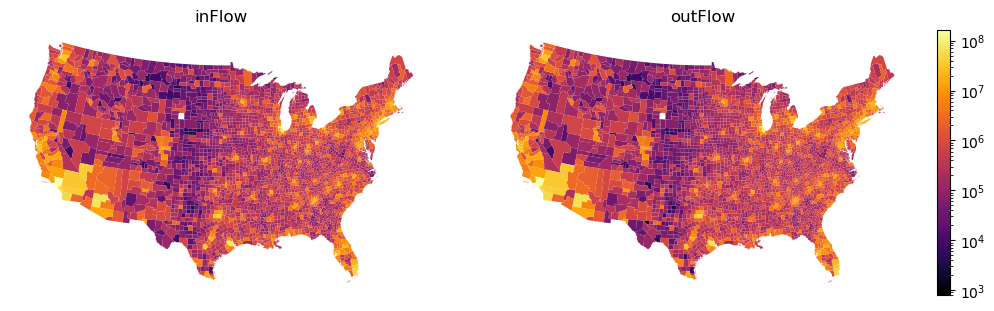

In [28]:
fig, axs = plt.subplots(figsize=(10, 3), ncols=2, layout='constrained')

# Set logarithmic normalization for color scaling
colorNorm = mpl.colors.LogNorm(vmin=geoData[['inFlow', 'outFlow']].min().min(), vmax=geoData[['inFlow', 'outFlow']].max().max())

# Plot 'inFlow' data
ax = axs[0]
ax.axis('off') 
ax.set_title('inFlow')
geoData.plot(column='inFlow', cmap='inferno', norm=colorNorm, ax=ax)

# Plot 'outFlow' data
ax = axs[1]
ax.axis('off')
ax.set_title('outFlow')
geoData.plot(column='outFlow', cmap='inferno', norm=colorNorm, ax=ax, legend=True)

<Figure size 640x480 with 0 Axes>

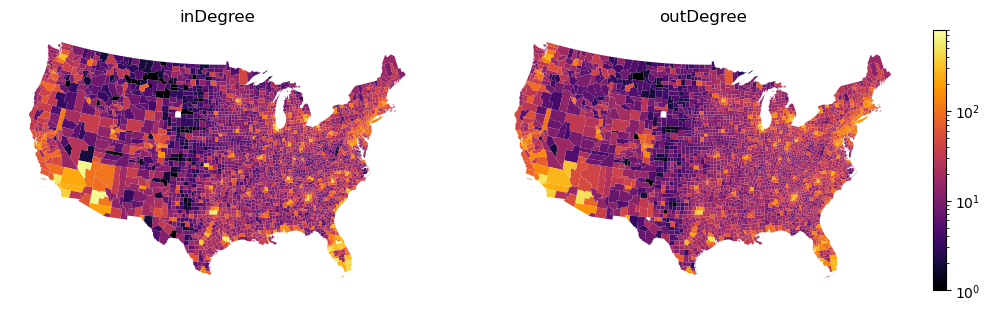

In [29]:
# Plot 'inFlow' and 'outFlow' data
fig, axs = plt.subplots(figsize=(10, 3), ncols=2, layout='constrained')
colorNorm=mpl.colors.LogNorm(vmin=geoData[['inDegree','outDegree']].min().min(), vmax=geoData[['inDegree','outDegree']].max().max())

ax = axs[0]
ax.axis('off')
ax.set_title('inDegree')
geoData.plot(column='inDegree', cmap='inferno', norm=colorNorm, ax=ax)

ax = axs[1]
ax.axis('off')
ax.set_title('outDegree')
geoData.plot(column='outDegree', cmap='inferno', norm=colorNorm, ax=ax, legend=True);

# Covid Lockdown

In [30]:
# Some FIPS codes related to NYC 
FIPS_NYC = {'36005', '36047', '36061', '36081', '36085', '35620'}

# Filter the data to obtain the VISITORS flow to NYC
# Alternative: Filter the data to obtain the VISITORS flow to NYC not originating from NYC
# Hint: use query with something similar to 'column in @FIPS_NYC'
visitorNYC = c2c.query("county_d in @FIPS_NYC")
#visitorNYC = c2c.query("(county_d in @FIPS_NYC) and not (county_o in @FIPS_NYC)")

# Use groupby to obtain the total visitors per day
visitorNYC = visitorNYC.groupby('date')['pop_flows'].sum()
visitorNYC.head(2)

date
2020-03-02    20642307.0
2020-03-03    20313250.0
Name: pop_flows, dtype: float64

In [31]:
# Repeat for San Francisco
FIPS_SanFrancisco = {'06075', '06081', '06013', '06001', '06041'}
visitorSF = c2c.query("county_d in @FIPS_SanFrancisco")
#visitorSF = c2c.query("(county_d in @FIPS_SanFrancisco) and not (county_o in @FIPS_SanFrancisco)")

visitorSF = visitorSF.groupby('date')['pop_flows'].sum()
visitorSF.head(2)

date
2020-03-02    10692712.0
2020-03-03    10869553.0
Name: pop_flows, dtype: float64

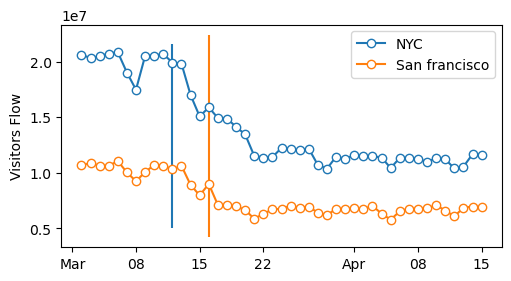

In [32]:
# Plot timeseries of visitors
fig, ax = plt.subplots(figsize=(5, 2.7), layout='constrained')

ax.plot(visitorNYC.index, visitorNYC.values, marker='o', markerfacecolor='white', label='NYC')
ax.plot(visitorSF.index,  visitorSF.values,  marker='o', markerfacecolor='white', label='San francisco')

dateFormat(ax)
ax.legend()
ax.set_ylabel('Visitors Flow');

ax.vlines(pd.Timestamp('2020-03-12'), *ax.get_ylim(), color='C0', alpha=1, zorder=-10)
ax.vlines(pd.Timestamp('2020-03-16'), *ax.get_ylim(), color='C1', alpha=1, zorder=-10)

In [ ]:
# What about rural areas?

# Add trip distances

In [240]:
# Load the JSON file with county coordinates
# If executing on Google Colab, change the path to:
# https://github.com/EPIcx-lab/ESPIDAM2024_Networks-and-Contact-Patterns-in-Infectious-Disease-Models/raw/main/otherData/US-counties.geojson
geoData = gpd.read_file('./otherData/US-counties.geojson')
geoData = geoData.to_crs("ESRI:102003")
geoData = geoData.set_index('id')

# Compute the centroid for each county
geoData["centroid"] = geoData.centroid

In [263]:
# Filter the data to obtain the VISITORS flow to NYC
FIPS_NYC = {'36005', '36047', '36061', '36081', '36085', '35620'}
FIPS_NYC = ["17037", "17063", "17091", "17093", "17099", "17103", "17105", "17111", "17141", "17007", "17075", "17053"]
#FIPS_NYC = {'17031'}

visitorNYC = c2c.query("county_d in @FIPS_NYC").copy()

In [264]:
# Map centroids to origin and destination counties in visitorNYC
# Hint: Use the function map on column county_o and county_d
visitorNYC['centroid_o'] = visitorNYC['county_o'].map(geoData['centroid'])
visitorNYC['centroid_d'] = visitorNYC['county_d'].map(geoData['centroid'])

In [265]:
visitorNYC.head(2)

,county_o,county_d,pop_flows,date,centroid_o,centroid_d
366,01003,17007,10.0,2020-04-14,POINT (789680.937 -722454.792),POINT (587099.468 562471.272)
369,01003,17037,10.0,2020-04-14,POINT (789680.937 -722454.792),POINT (595119.812 514835.759)


In [266]:
# Compute the distances
visitorNYC['distance'] = gpd.GeoSeries(visitorNYC['centroid_o'], crs="ESRI:102003").distance(gpd.GeoSeries(visitorNYC['centroid_d'], crs="ESRI:102003"))

# Convert distance from meters to kilometers
visitorNYC['distance'] /= 1000

# Display the first 2 rows of the resulting DataFrame
visitorNYC.head(2)

,county_o,county_d,pop_flows,date,centroid_o,centroid_d,distance
366,01003,17007,10.0,2020-04-14,POINT (789680.937 -722454.792),POINT (587099.468 562471.272),1300.797540
369,01003,17037,10.0,2020-04-14,POINT (789680.937 -722454.792),POINT (595119.812 514835.759),1252.494286


## Long vs Short mobility

In [275]:
# Create two dataset containing long and short mobility
...
distanceTh = 700
short = visitorNYC.query('distance < @distanceTh')
long = visitorNYC.query('distance >= @distanceTh')

In [276]:
# Use groupby to obtain the total visitor per day
...
long = long.groupby('date')['pop_flows'].sum()
short = short.groupby('date')['pop_flows'].sum()

In [277]:
# Normalize the timeseries
# Take the period before the restrictions (ex '2020-03-18') and compute the average number of visitor
# Divide the whole timeseies by the average pre-intervention number of visitors 
...
long /= long.loc[long.index.min()]
short /= short.loc[long.index.min()]

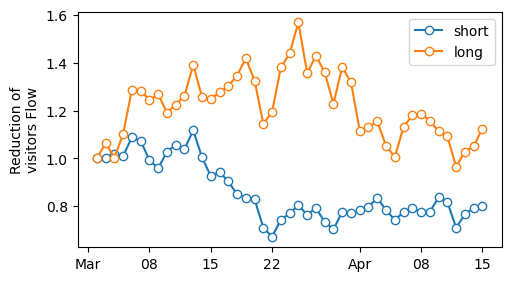

In [278]:
# Plot the timeseries
... 
fig, ax = plt.subplots(figsize=(5, 2.7), layout='constrained')

ax.plot(short.index, short.values, marker='o', markerfacecolor='white', label='short')
#ax2 = ax.twinx()
ax.plot(long.index, long.values, marker='o', markerfacecolor='white', label='long', c='C1')

locator = mdates.AutoDateLocator(minticks=5, maxticks=10)
formatter = mdates.ConciseDateFormatter(locator, show_offset=False)
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(formatter)
ax.legend()
ax.set_ylabel('Reduction of\nvisitors Flow');

# Gravity Model for Mobility

The gravity model for mobility is a mathematical model used to predict and describe the movement of individuals between different locations. 
It is analogous to Newton's law of gravitation, where the interaction between two locations is proportional to their "masses" (e.g., population sizes) and inversely proportional to the distance between them. 
The generalized gravity model introduces exponents to all the coefficients, allowing for more flexibility and accuracy in capturing the complexities of human mobility.


The formula for the generalized gravity model is given by:
$$T_{ij} = k \frac{P_i^{\alpha} P_j^{\beta}}{D_{ij}^{\gamma}}$$

where:
- $ T_{ij} $ is the predicted flow from location $ i $ to location $ j $
- $P_i $ and $ P_j $ are the populations of locations $ i $ and $ j $, respectively
- $D_{ij} $ is the distance between locations $ i $ and $ j $
- $k $ is a constant
- $\alpha $, $ \beta $, and $ \gamma $ are the exponents that adjust the influence of the populations and distance on the flow  


Here we fit a gravity model to describe the flow **between states**  
We are going to fit the model by applying the log of both side so that we obtain a linear model
$$\log(T_{ij}) = \log(k) + \alpha \log(P_i) + \beta \log({P_j}) - \gamma \log({D_{ij})}$$


In [54]:
# Load US population dataset 
# (if executed on Google Colab change the path in 'https://github.com/EPIcx-lab/ESPIDAM2024_Networks-and-Contact-Patterns-in-Infectious-Disease-Models/raw/main/otherData/US-pop-states.csv')

popState = pd.read_csv("./otherData/US-pop-states.csv")

popState['state'] = popState['state'].astype(str)
popState['state'] = popState['state'].apply(lambda a: a.zfill(2)) 
popState = popState.set_index('state')
popState.head(2)

,pop
state,
01,4830620
02,733375


In [55]:
# load population dataset 
# (if executed on Google Colab change the path in 'https://github.com/francescoParino/ESPIDAM/raw/main/otherData/US-states.geojson')

geoState = gpd.read_file('./otherData/US-states.geojson')
geoState = geoState.to_crs("ESRI:102003")
geoState = geoState.set_index('GEOID')

# Compute the controid for each county
geoState["centroid"] = geoState.centroid

In [56]:
# filter in time 
s2s = c2c.query('"2020-03-02" <= date <= "2020-03-06"').copy()

# Aggregate the flow at state level
# add column that identify the state
s2s['state_o'] = s2s['county_o'].map(lambda a: a[0:2])
s2s['state_d'] = s2s['county_d'].map(lambda a: a[0:2])

# remove within state travel
s2s = s2s.query('state_o != state_d').copy()

# aggreagte summing the flow data at state level
s2s = s2s.groupby(['state_o','state_d','date'])['pop_flows'].sum()
s2s = s2s.reset_index()

# aggreagte and compute the mean over time 
s2s = s2s.groupby(['state_o','state_d'])['pop_flows'].mean()
s2s = s2s.reset_index()

In [57]:
# add centroid of the origin and destination
s2s['centroid_o'] = s2s['state_o'].map(geoState['centroid'])
s2s['centroid_d'] = s2s['state_d'].map(geoState['centroid'])
s2s = s2s.dropna()

# compute distance between centroid
s2s['distance'] = gpd.GeoSeries(s2s['centroid_o'], crs="ESRI:102003").distance(gpd.GeoSeries(s2s['centroid_d'], crs="ESRI:102003"))

# distance from m to km
s2s['distance'] /= 1000

In [58]:
# add columns for the population of the origin and destination
s2s['pop_o'] = popState.loc[s2s['state_o']].values
s2s['pop_d'] = popState.loc[s2s['state_d']].values

In [59]:
# prepare the variables
P_i = s2s['pop_o'].values
P_j = s2s['pop_d'].values
D_ij = s2s['distance'].values
T_ij = s2s['pop_flows'].values

# Design matrix
X = np.column_stack((np.log10(P_i), np.log10(P_j), np.log10(D_ij)))
X = sm.add_constant(X)

# Fit the model
model = sm.OLS(np.log10(T_ij), X)
results = model.fit()

# Extract the parameters
K_fitted = 10**results.params[0]
a_fitted = results.params[1]
c_fitted = results.params[2]
b_fitted = results.params[3]

print(f"Fitted parameters:\nK = {K_fitted}\na = {a_fitted}\nb = {b_fitted}\nc = {c_fitted}")

Fitted parameters:
K = 4.615866419132182e-05
a = 0.8419090002983467
b = -1.0734934516215109
c = 0.8592283786322104


In [317]:
# Predict the travel flows using the fitted parameters
T_ij_predicted = K_fitted * (P_i ** a_fitted) * (P_j ** c_fitted) * (D_ij ** b_fitted)

Text(0, 0.5, 'predicted flow')

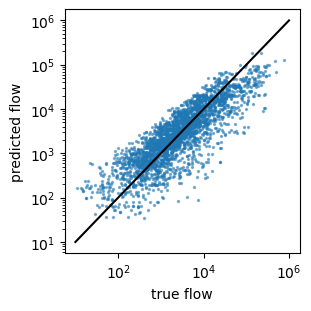

In [318]:
fig, ax = plt.subplots(figsize=(3,3), layout='constrained')
ax.scatter(T_ij, T_ij_predicted, s=2, alpha=0.5)
ax.plot([1e1,1e6], [1e1,1e6], color='black')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('true flow')
ax.set_ylabel('predicted flow')

# Visualize the travel network

In [ ]:
!pip install networkx

In [136]:
import networkx as nx

In [207]:
hideStates = ['02', '69','44' ,'66' ,'15' ,'60' ,'78' ,'72']

In [384]:
# Take the state-to-state network and duplicate it
links = s2s.copy()
links = links.reset_index()
links.head(2)

,index,state_o,state_d,pop_flows,centroid_o,centroid_d,distance,pop_o,pop_d
0,0,01,02,263.4,POINT (852662.1620269344 -487014.8285876673),POINT (-3080848.690079577 3759820.3363097515),5788.619571,4830620,733375
1,1,01,04,3304.4,POINT (852662.1620269344 -487014.8285876673),POINT (-1424361.1659855302 -243220.11070067785),2290.037358,4830620,6641928


In [385]:
# Filter rows where pop_flows is greater than 1000
...
links = links.query('pop_flows > 1000')

# Remove flows within the same state.
...
links = links.query('state_o != state_d')

# Remove flows that include the hidden states.
# Hint: Use the query method and access the local variable hideStates with @hideStates in the query string.
...
links = links.query("(state_o not in @hideStates) and (state_d not in @hideStates)")

In [386]:
# Transform the flow into values between 0 and 10 to represent the weights of the links in the network.
# Create a new column 'w' for the weights
...
minVal, maxVal = links['pop_flows'].min(), links['pop_flows'].max()
links['w'] = (links['pop_flows'] - minVal) * (10 / (maxVal - minVal))

In [394]:
# Load the US states shapefile
geoState = gpd.read_file('./otherData/US-states.geojson')
geoState = geoState.to_crs("ESRI:102003")
geoState = geoState.query("STATEFP not in @hideStates")

In [388]:
# Create a NetworkX graph
G = nx.Graph()

# Add nodes to the graph named with the state code.
# Hint: Iterate over the geoState dataframe and use G.add_node() to add each state.
...
for state in geoState['STATEFP']:
    G.add_node(state)

In [390]:
# Add links to the graph
# Hint: Iterate over the links dataframe and use G.add_edge(nodeFrom, nodeTo, weight=) to add each link.
for index, val in links.iterrows():
    ...
    G.add_edge(val['state_o'], val['state_d'], weight=val['w'])

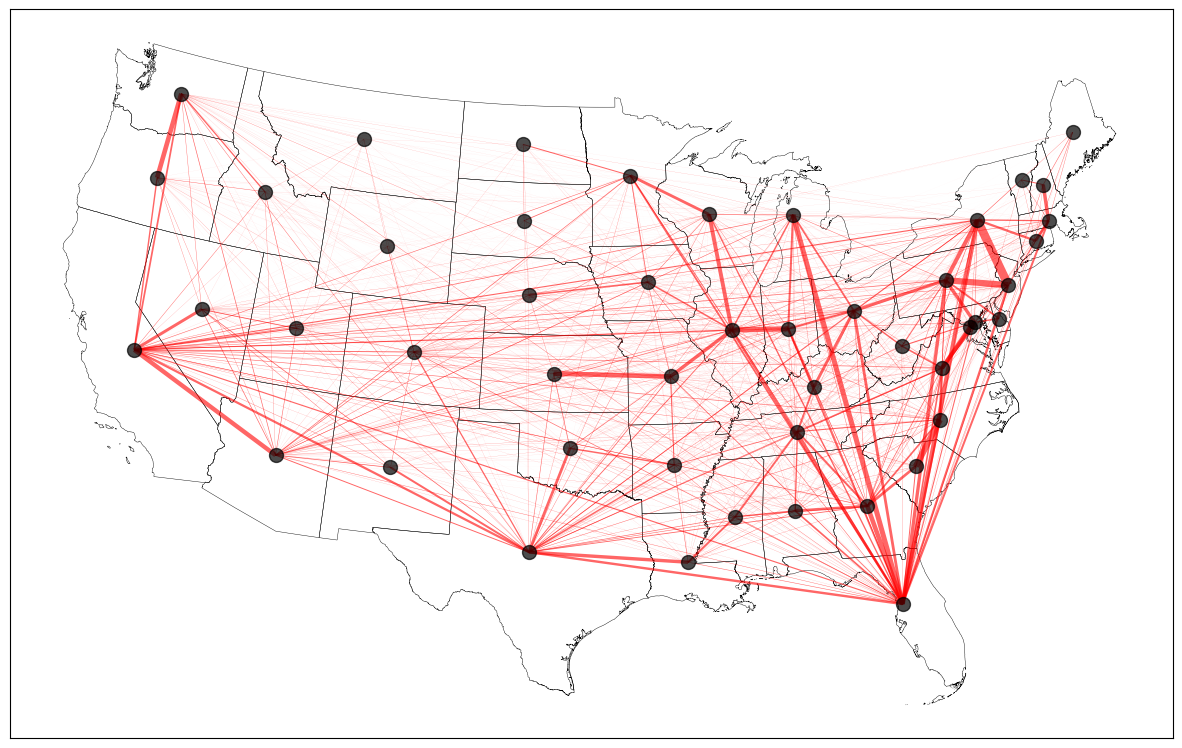

In [396]:
# Plot the US states.
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
geoState.plot(facecolor='None', linewidth=0.3, ax=ax)

# Create a dictionary for each state code with two values (x, y) equal to the centroid.
# Hint: Iterate over geoState, calculate the centroid, and access the properties x and y.
...
pos = {}
for _, row in geoState.iterrows():
    pos[row['STATEFP']] = (row['geometry'].centroid.x, row['geometry'].centroid.y)

# Draw the network nodes on top of the map.
nx.draw_networkx_nodes(G, pos,
                       node_size=100,
                       node_color='black',
                       alpha=0.7)

# Get edge widths from the graph and draw the network edges
widths = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edges(G, pos,
                       edgelist=widths.keys(),
                       width=list(widths.values()),
                       edge_color='red',
                       alpha=0.6)

# Importation risk

If a disease is detected in county A. Which are the countries at highest risk of importing a case from county A? 
The risk of importation from a county A to a county B is can be defined as the probability of traveling from A to B, conditional on traveling.  
In other words: let us assume that an infected person is about to travel out of the country. Where will they go? Importation risk to country B is the probability that they will go to B.  

So we can turn the definition of risk into a mathematical law:   
$$C_{ab} = \frac{W_{ab}}{W_a}$$

where the sum of is computed over all countries except the origin country , to obtain the probabily of traveling from to conditionally to traveling outside of . Here, is the risk matrix: is the probability that a case traveling out of country a, ends up in country b. As you can see, this formula is extremely simple and relies on mobility. Nowhere we needed epidemiological data!

## Prepare the dataset

In [403]:
# Select a certain date from the c2c DataFrame
...
df = c2c.query('date == "2020-03-02"')

In [404]:
# Compute the denominator W_a
# Hint: Use groupby to aggregate the total population flows
Wa = df.groupby('county_o')['pop_flows'].sum()
Wa.name = 'Wa'

In [409]:
# add the denominator W_a to our dataset
# Hint: in each row we need to add Wa to the corresponding couty of origin. Use df.merge(...)
df = df.merge(Wa, left_on='county_o', right_index = True)

In [411]:
df.head(2)

,county_o,county_d,pop_flows,date,Wa_x,C,Wa_y
17653568,01001,01001,90187.0,2020-03-02,142635.0,0.632292,142635.0
17653569,01001,01003,63.0,2020-03-02,142635.0,0.000442,142635.0


In [407]:
# Now Cab
...
df['C'] = df['pop_flows']/df['Wa']

In [408]:
df.head(2)

,county_o,county_d,pop_flows,date,Wa,C
17653568,01001,01001,90187.0,2020-03-02,142635.0,0.632292
17653569,01001,01003,63.0,2020-03-02,142635.0,0.000442


## Select a source county and plot on a map the risk 

In [414]:
# Load the json file with county coordinates
geoData = gpd.read_file('https://raw.githubusercontent.com/holtzy/The-Python-Graph-Gallery/master/static/data/US-counties.geojson')
geoData = geoData.to_crs("ESRI:102003")
geoData = geoData.set_index('id')

hideStates = ['02', '69','44' ,'66' ,'15' ,'60' ,'78' ,'72']
geoData = geoData.query("STATE not in @hideStates")

In [415]:
geoData.head(2)

,GEO_ID,STATE,COUNTY,NAME,LSAD,CENSUSAREA,geometry
id,,,,,,,
01001,0500000US01001,01,001,Autauga,County,594.436,"POLYGON ((888385.589 -532160.711, 867146.329 -..."
01009,0500000US01009,01,009,Blount,County,644.776,"POLYGON ((865138.928 -375110.799, 847724.195 -..."


In [416]:
# Create a new database for a selected source
# Hint: Filter the DataFrame for rows where 'county_o' matches the selected source code
...
source = '36061'
dfSource = df.query('county_o == @source')

In [417]:
# Merge geoData with dfSource
# Hint: Use the merge function to combine geoData and dfSource.
geoDataC = geoData.merge(dfSource, left_index=True, right_on='county_d')

In [418]:
geoDataC.head(2)

,GEO_ID,STATE,COUNTY,NAME,LSAD,CENSUSAREA,geometry,county_o,county_d,pop_flows,date,Wa_x,C,Wa_y
17867076,0500000US01017,01,017,Chambers,County,596.531,"POLYGON ((1003933.242 -460749.207, 1010796.008...",36061,01017,26.0,2020-03-02,3536275.0,0.000007,3536275.0
17867081,0500000US01079,01,079,Lawrence,County,690.678,"POLYGON ((807251.107 -277301.493, 808203.510 -...",36061,01079,79.0,2020-03-02,3536275.0,0.000022,3536275.0


<Axes: >

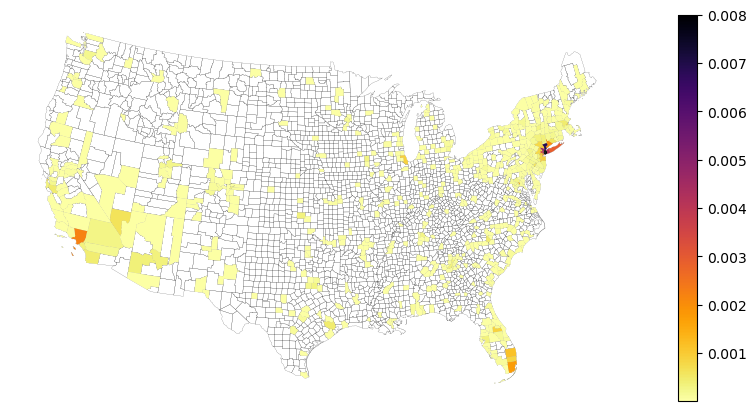

In [420]:
fig, ax = plt.subplots(figsize=(12, 4), ncols=1, layout='constrained')

# Remove axis
ax.axis('off')

# Plot the whole map
geoData.plot(facecolor='None', ax=ax, linewidth=0.1)

# Plot the source in green
# Hint: select from geoData only the source and use plot
...
geoData.loc[[source]].plot(facecolor='green', ax=ax, linewidth=0)

# Plot the destination color based on risk C.
# Hint: Use the plot method to plot geoDataC with a colormap 'inferno_r', no lines, and a legend.
geoDataC.plot(column='C', cmap='inferno_r', ax=ax, linewidth=0, vmax=0.008, legend=True)